# Configuration

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse


# Importing dataset 

In [4]:
std_df = pd.read_csv('processed_dataset/std_dataset.csv', index_col = 0)
std_df.shape

(36733, 39)

In [6]:
dev_df = std_df.loc[:24487,:]
dev_df.shape

(24488, 39)

In [8]:
eval_df = std_df.loc[24488:, :]
eval_df.shape

(12245, 39)

# Model building 

In [55]:
class Model():
    
    def __init__(self, model_classifier, standard_regressor, extreme_regressor):
        
        self.classifier = model_classifier
        self.std_regr = standard_regressor
        self.ext_regr = extreme_regressor
        
    def fit(self, X, co_values, binary_labels):
        
        self.classifier.fit(X,binary_labels)
        print('Classifier fitted')
        
        mask = binary_labels.values == 0
        std_X, std_co_values = X.loc[mask,:], co_values.loc[mask]
        ext_X, ext_co_values = X.loc[~mask,:], co_values.loc[~mask]
        
        print(std_X.shape, ext_X.shape)
        
        self.std_regr.fit(std_X, std_co_values)
        print('Standard Regressor fitted')
        self.ext_regr.fit(ext_X, ext_co_values)
        print('Extrem Regressor fitted')
        
        return True
    
    def predict(self,X):
        
        pred_labels = self.classifier.predict(X)
        
        mask = pred_labels == 0
        std_X = X.loc[mask, :]
        ext_X = X.loc[~mask, :]
        
        std_pred = self.std_regr.predict(std_X)
        ext_pred = self.ext_regr.predict(ext_X)
        
        y_pred = np.zeros(shape = pred_labels.shape)
        y_pred[mask] = std_pred
        y_pred[~mask] = ext_pred
        
        return y_pred
        
        

In [20]:
dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 4.5 else 1)
dev_df[['CO','labels']]

/tmp/ipykernel_2882/3230006167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 4.5 else 1)


,CO,labels
ID,,
0,1.07640,0
1,10.19600,1
2,0.78407,0
3,1.61530,0
4,1.40710,0
...,...,...
24483,1.60010,0
24484,2.21050,0
24485,2.00960,0


In [23]:
dev_df['CO'].loc[dev_df['CO'] < 4.5,].count()

21652

In [25]:
dev_df['labels'].value_counts()

0    21652
1     2836
Name: labels, dtype: int64

In [75]:
X = dev_df.drop(columns = ['CO', 'labels'])
co_values = dev_df['CO']
labels = dev_df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, pd.DataFrame({'CO': co_values, 'labels':labels}),
                                                    random_state=42, test_size=0.25,
                                                    stratify=dev_df['labels'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((18366, 38), (6122, 38), (18366, 2), (6122, 2))

In [77]:
X_train.columns

Index(['YEAR', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP',
       'NOX', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'Poland', 'Portugal', 'Republic of Cyprus',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'],
      dtype='object')

In [78]:
clf = RandomForestClassifier()
std_regr = RandomForestRegressor()
ext_regr = RandomForestRegressor()

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)
model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Classifier fitted
(16239, 38) (2127, 38)
Standard Regressor fitted
Extrem Regressor fitted


True

In [86]:
y_pred = model.predict(X_test)

In [80]:
mse(y_test['CO'].values, y_pred)

1.4415824649186537

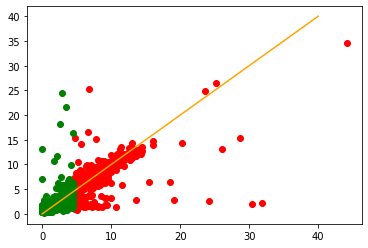

In [88]:
plt.scatter(y_test['CO'].loc[y_test['labels'] == 1].values, y_pred[y_test['labels'] == 1], c = 'red')
plt.scatter(y_test['CO'].loc[y_test['labels'] == 0].values, y_pred[y_test['labels'] == 0], c = 'green')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'orange')

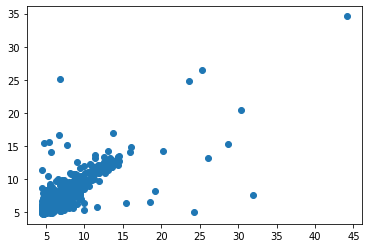

In [84]:
y_ext = model.ext_regr.predict(X_test.loc[y_test['labels'] == 1,:])
plt.scatter(y_test['CO'].loc[y_test['labels']==1], y_ext)